###### In this notebook we will be doing some sentimental analysis in python using      two different techniques:

##  1.VADER(Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
##  2.Roberta Pretrained Model from 🤗
##  3.Huggingface Pipeline


# Step 1 :Read in Data and NLTK Basics

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.data.path.append('C:/Users/HP/AppData/Roaming/nltk_data') 
nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Read in data
df = pd.read_csv('amazon.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(4915, 12)
(500, 12)


In [13]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


## Quick EDA

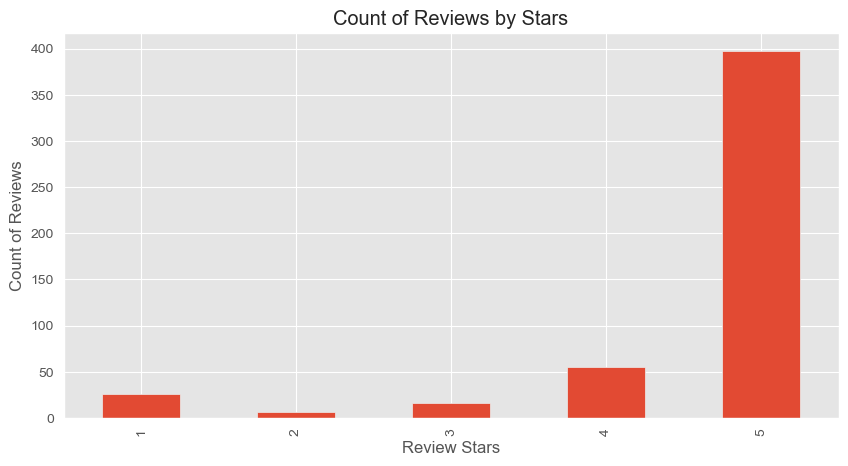

In [14]:
import matplotlib.pyplot as plt

# Plotting the count of reviews by stars
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count of Reviews')
plt.show()

## Basic NLTK

In [15]:
example = df['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [18]:
tokens = nltk.word_tokenize(example)
print(tokens[:10])

['A', 'memory', 'card', 'either', 'works', 'or', 'it', 'does', "n't", '.']


In [19]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('A', 'DT'),
 ('memory', 'NN'),
 ('card', 'NN'),
 ('either', 'CC'),
 ('works', 'VBZ'),
 ('or', 'CC'),
 ('it', 'PRP'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('.', '.')]

In [20]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  does/VBZ
  n't/RB
  ./.
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


# Step 2. VADER Seniment Scoring
### We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

#### This uses a "bag of words" approach:
####    1.Stop words are removed
####    2.each word is scored and combined to a total score.

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [22]:
 sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [23]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [24]:
sia.polarity_scores(example)

{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [39]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviewText']  # Access the review text
    myid = i  # Use the DataFrame index as the id
    
    # Skip rows with missing or invalid text
    if not isinstance(text, str):
        continue
    
    # Compute sentiment polarity scores
    res[myid] = sia.polarity_scores(text)

# Convert the results to a DataFrame for easier analysis
res_df = pd.DataFrame(res).T  # Transpose to match DataFrame format
res_df.index.name = 'id'

# Display the first few rows of the results
print(res_df.head())

100%|██████████| 500/500 [00:00<00:00, 968.52it/s]

      neg    neu    pos  compound
id                               
0   0.688  0.312  0.000   -0.2960
1   0.075  0.925  0.000   -0.2960
2   0.077  0.923  0.000   -0.3089
3   0.000  0.909  0.091    0.7081
4   0.038  0.835  0.127    0.7087


In [40]:
# Convert the results dictionary to a DataFrame and reset the index
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})  # Rename the index column to 'id'

# Merge the sentiment scores with the original dataset on the index
vaders = vaders.merge(df.reset_index(), how='left', left_on='id', right_on='index')

# Drop the redundant 'index' column from the merged DataFrame
vaders = vaders.drop(columns=['index'])

# Display the first few rows of the merged DataFrame
print(vaders.head())

   id    neg    neu    pos  compound  Unnamed: 0  reviewerName  overall  \
0   0  0.688  0.312  0.000   -0.2960           0           NaN        4   
1   1  0.075  0.925  0.000   -0.2960           1          0mie        5   
2   2  0.077  0.923  0.000   -0.3089           2           1K3        4   
3   3  0.000  0.909  0.091    0.7081           3           1m2        5   
4   4  0.038  0.835  0.127    0.7087           4  2&amp;1/2Men        5   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  23-07-2014       138   
1  Purchased this for my device, it worked as adv...  25-10-2013       409   
2  it works as expected. I should have sprung for...  23-12-2012       715   
3  This think has worked out great.Had a diff. br...  21-11-2013       382   
4  Bought it with Retail Packaging, arrived legit...  13-07-2013       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0    

In [41]:
# Now we have sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,0.688,0.312,0.000,-0.2960,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0.075,0.925,0.000,-0.2960,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,0.077,0.923,0.000,-0.3089,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,0.000,0.909,0.091,0.7081,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,0.038,0.835,0.127,0.7087,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


# Plot VADER results

C:\Users\HP\AppData\Local\Temp\ipykernel_13520\3890910443.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=vaders, x='overall', y='compound', ci=None)


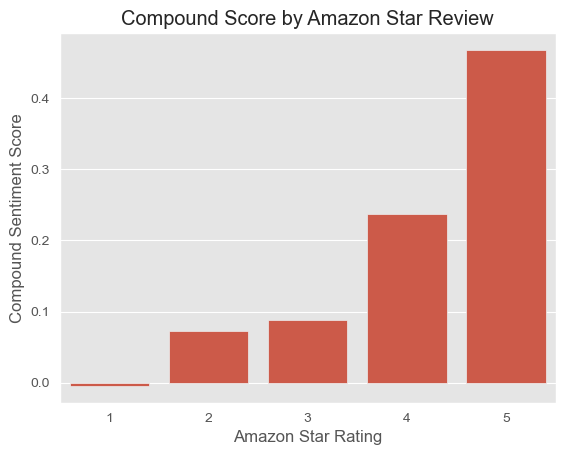

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use 'overall' as the star rating (Amazon review stars) and 'compound' as the sentiment score
ax = sns.barplot(data=vaders, x='overall', y='compound', ci=None)

# Set the title and axis labels
ax.set_title('Compound Score by Amazon Star Review')
ax.set_xlabel('Amazon Star Rating')
ax.set_ylabel('Compound Sentiment Score')

# Display the plot
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13520\4184610919.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0], ci=None)
C:\Users\HP\AppData\Local\Temp\ipykernel_13520\4184610919.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1], ci=None)
C:\Users\HP\AppData\Local\Temp\ipykernel_13520\4184610919.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2], ci=None)


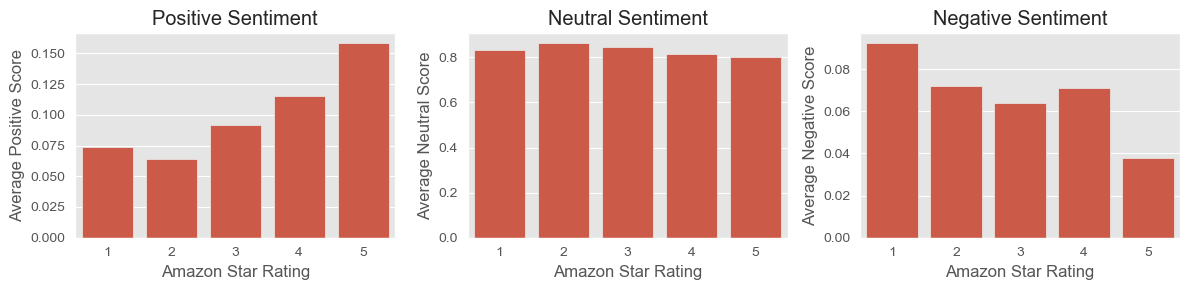

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots for positive, neutral, and negative sentiment scores
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot positive sentiment scores
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0], ci=None)
axs[0].set_title('Positive Sentiment')
axs[0].set_xlabel('Amazon Star Rating')
axs[0].set_ylabel('Average Positive Score')

# Plot neutral sentiment scores
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1], ci=None)
axs[1].set_title('Neutral Sentiment')
axs[1].set_xlabel('Amazon Star Rating')
axs[1].set_ylabel('Average Neutral Score')

# Plot negative sentiment scores
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2], ci=None)
axs[2].set_title('Negative Sentiment')
axs[2].set_xlabel('Amazon Star Rating')
axs[2].set_ylabel('Average Negative Score')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Step 3. Roberta Pretrained Model
### Use a model trained of a large corpus of data.
### Transformer model accounts for the words but also the context related to other words.

In [44]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [49]:
# VADER results on example
print(example)
sia.polarity_scores(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [54]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax

# Define the model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# Process example text
example = "I love using this product! It's amazing and works perfectly."

# Encode text and pass through the model
encoded_text = tokenizer(example, return_tensors='tf')  # Use 'tf' for TensorFlow
output = model(encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)

# Convert scores to a dictionary
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


{'roberta_neg': 0.0021480483, 'roberta_neu': 0.0052233897, 'roberta_pos': 0.9926286}


In [55]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [58]:
from tqdm import tqdm
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax

# Initialize Vader Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Load the RoBERTa Model and Tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to get RoBERTa polarity scores
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='tf')
    output = model(encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    return {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

# Initialize result dictionary
res = {}

# Loop through each row of the DataFrame
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviewText']  # Use 'reviewText' from your dataset
        myid = i  # Use the index of the row as the ID

        # Vader Sentiment Analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        # RoBERTa Sentiment Analysis
        roberta_result = polarity_scores_roberta(text)

        # Combine both results
        both = {**vader_result_rename, **roberta_result}

        # Store the results using the index as the ID
        res[myid] = both
    except Exception as e:
        print(f'Broke for id {i} with error: {e}')

# Convert results to DataFrame
vaders_roberta_df = pd.DataFrame.from_dict(res, orient='index')
vaders_roberta_df.reset_index(inplace=True)
vaders_roberta_df.rename(columns={'index': 'Id'}, inplace=True)

# Merge with the original DataFrame (if needed)
final_df = df.merge(vaders_roberta_df, left_index=True, right_on='Id', how='left')

print(final_df.head())

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
 15%|█▌        | 76/500 [00:33<03:43,  1.89it/s]

Broke for id 76 with error: Exception encountered when calling layer 'embeddings' (type TFRobertaEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 514 is not in [0, 514) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFRobertaEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 1066), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 1066), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False


 25%|██▍       | 123/500 [00:58<03:51,  1.63it/s]

Broke for id 123 with error: Exception encountered when calling layer 'embeddings' (type TFRobertaEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 514 is not in [0, 514) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFRobertaEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 1167), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 1167), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False


 25%|██▌       | 125/500 [00:58<02:48,  2.22it/s]

Broke for id 125 with error: 'float' object is not iterable


100%|██████████| 500/500 [03:28<00:00,  2.40it/s]


     Unnamed: 0  reviewerName  overall  \
0.0           0           NaN        4   
1.0           1          0mie        5   
2.0           2           1K3        4   
3.0           3           1m2        5   
4.0           4  2&amp;1/2Men        5   

                                            reviewText  reviewTime  day_diff  \
0.0                                         No issues.  23-07-2014       138   
1.0  Purchased this for my device, it worked as adv...  25-10-2013       409   
2.0  it works as expected. I should have sprung for...  23-12-2012       715   
3.0  This think has worked out great.Had a diff. br...  21-11-2013       382   
4.0  Bought it with Retail Packaging, arrived legit...  13-07-2013       513   

     helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0.0            0           0           0                   0   
1.0            0           0           0                   0   
2.0            0           0           0                   0   
3.0       

In [60]:
import pandas as pd

# Create DataFrame from the sentiment analysis results (assuming 'res' holds the results dictionary)
results_df = pd.DataFrame(res).T

# Reset index to add the row index as a column and rename it to 'Id'
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

# Merge sentiment analysis results with your original DataFrame (df) using the index as the key
# Assuming 'df' does not have an explicit 'Id', we will merge on the index directly
results_df = results_df.merge(df, left_on='Id', right_index=True, how='left')

# Now results_df contains both the sentiment scores and your original dataset
print(results_df.head())

   Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0   0      0.688      0.312      0.000         -0.2960     0.074959   
1   1      0.068      0.932      0.000         -0.2960     0.007265   
2   2      0.070      0.930      0.000         -0.3089     0.423756   
3   3      0.000      0.916      0.084          0.7081     0.002447   
4   4      0.036      0.843      0.120          0.7087     0.003552   

   roberta_neu  roberta_pos  Unnamed: 0  reviewerName  overall  \
0     0.589215     0.335826           0           NaN        4   
1     0.095529     0.897206           1          0mie        5   
2     0.448311     0.127933           2           1K3        4   
3     0.019229     0.978324           3           1m2        5   
4     0.067458     0.928989           4  2&amp;1/2Men        5   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  23-07-2014       138   
1  Purchased this fo

# Compare Scores between models

In [61]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0',
       'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff',
       'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

# Step 3. Combine and compare

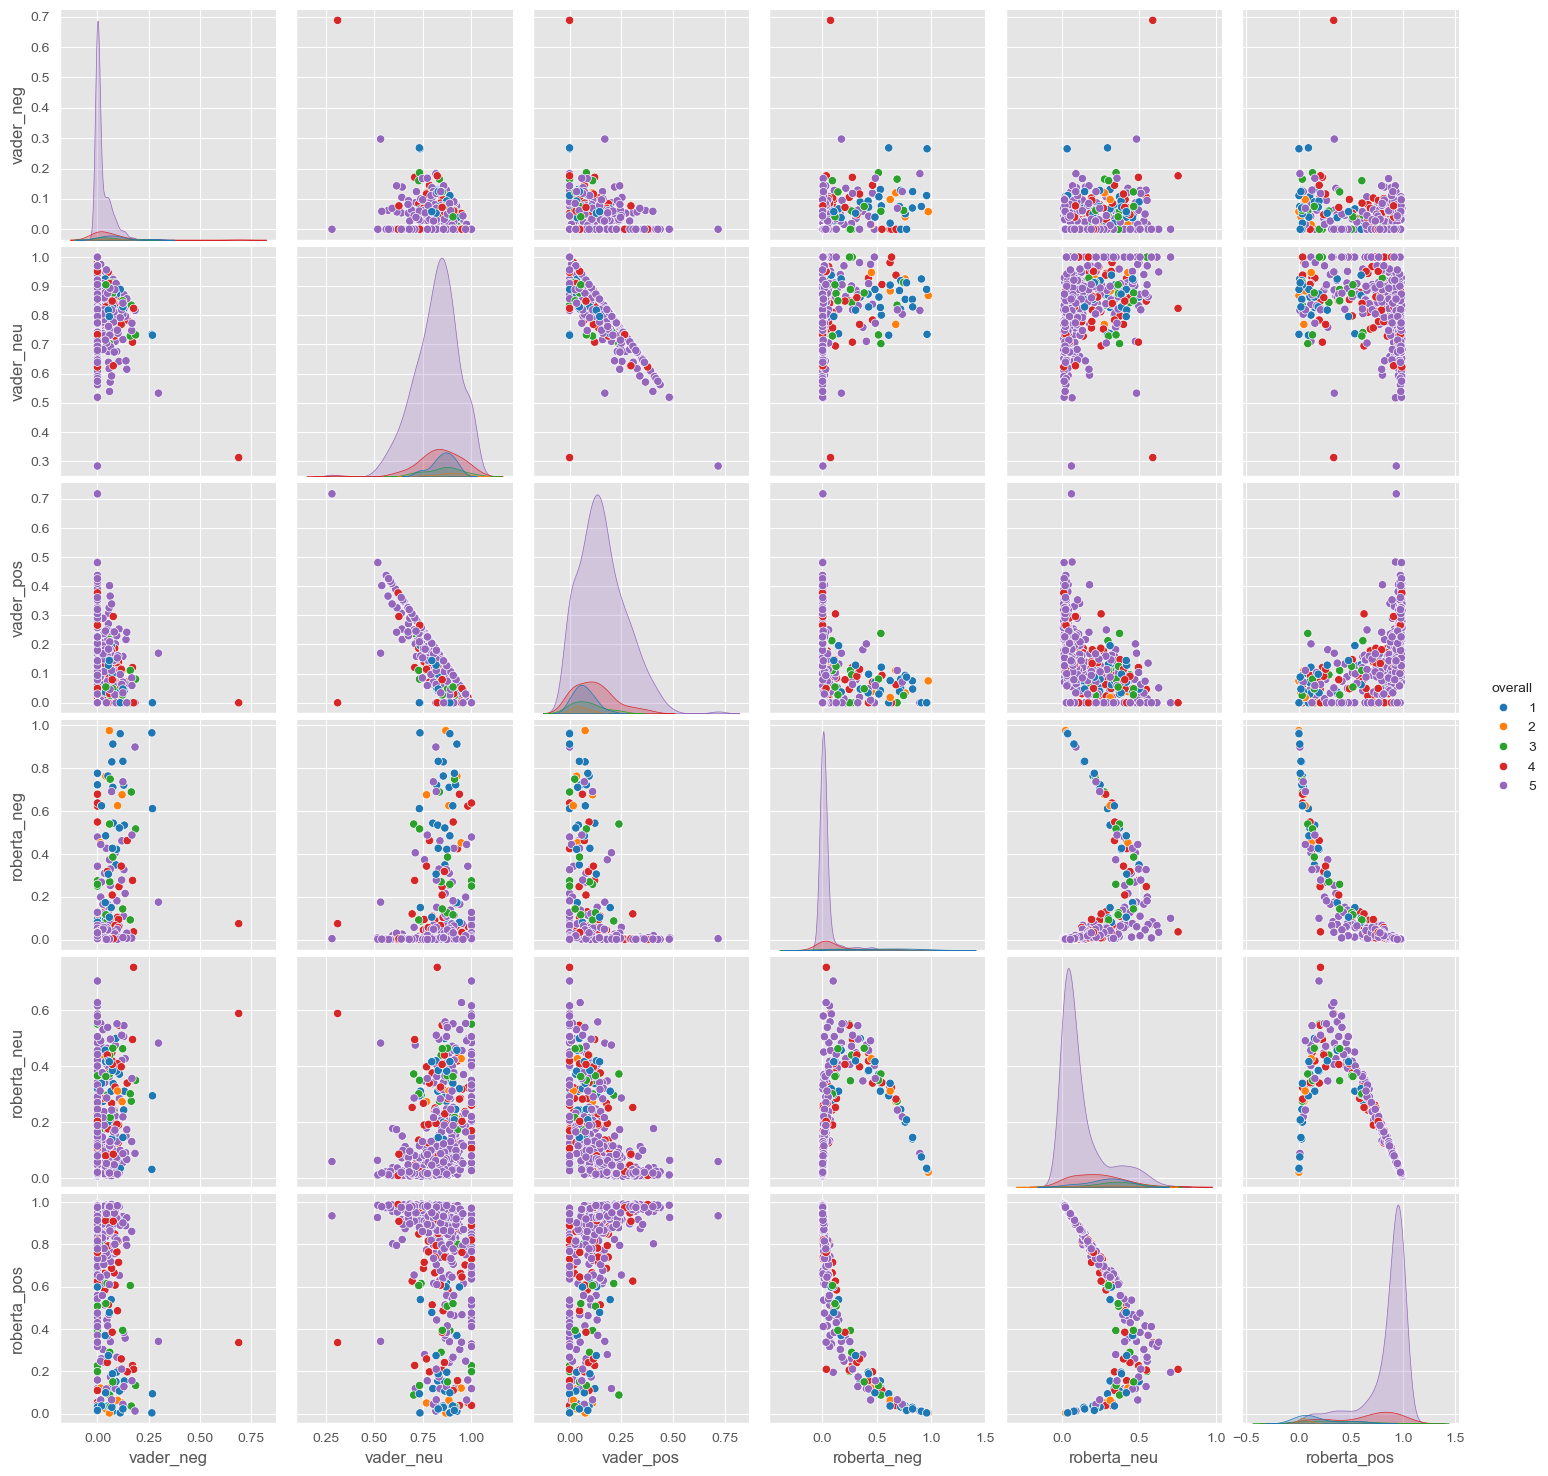

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Score' is the review rating column in your dataset (replace with correct column name if needed)
# and the sentiment columns (vader_neg, vader_neu, vader_pos, roberta_neg, roberta_neu, roberta_pos) are present.

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='overall',   
             palette='tab10')   

plt.show()

# Step 4: Review Examples:
##      Positive 1-Star and Negative 5-Star Reviews
###      Lets look at some examples where the model scoring and review score differ the most.

In [64]:
# Filter for rows where the review score is 1, sort by 'roberta_pos', and select the text of the highest 'roberta_pos' score
results_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

'I bougth this micro SD card after some trubles with other that i got from Kingston, i can tell that SanDisk is other quality, this is the best, my i9300 phone can read a 64GB very fast, the dta transfer speed from my pc to my is amazing, if you are looking for additional storage to you phone, for music, pictures and other type of files, this is for you.Pros-Very good quality materials of construction-Amazing speedUpdate after one year this memory is damaged I can not delete or put new files on it, I can not format this memory, I tried to format with my phone, with my pc, with a camera and nothing, now this is like a 64gb cd, the data in the memory is only available to read but I can not move, or delete it, I bought this memory to be used to backup all my data of my android device but now is only a readable memory I can not write data on it any more, I hope sandisk make a better products in the future!!! Total disagree I will buy a Samsung memory card expected a better quality.'

In [65]:
# Filter for rows where the review score is 1, sort by 'vader_pos', and select the text of the highest 'vader_pos' score
results_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)['reviewText'].values[0]

'I bought this card on the strength of the 64GB XDSC SanDisk in my phone right now.  It was a gift for a friend of mine and sadly it corrupted within minutes of first use.Initially it worked fine, then dead.  We checked in a laptop and Windows Disk Management screen told me it had a single 128K partition and the rest was unusable.  Outstanding.The replacement sent by Amazon (Thank you Amazon, you are always excellent) is sitting in my office right now, I should probably check it out.'

In [31]:
# nevative sentiment 5-Star view

In [66]:
# Filter for rows where the review score is 5, sort by 'roberta_neg', and select the text of the highest 'roberta_neg' score
results_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

'Appears to be Class 10, holds about as much as it says it does, came with an SD card adapter and they even gave me the option to forgo those ridiculous plastic packages that you all know and hate. The ones that the scissors refuse to cut and you just end up hurting yourself a few times before getting it open. Completely as advertised.'

In [67]:
# Filter for rows where the review score is 5, sort by 'vader_neg', and select the text of the highest 'vader_neg' score
results_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]

'This works with the NL1520.  No video stuttering like with the 64gb.  Blah blah blah blah to fill in the rest.'

#  Extra: The Transformers Pipeline
##        Quick & easy way to run sentiment predictions

In [68]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\HP\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [69]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [70]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [80]:
import tensorflow as tf

# Assuming you have a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Train the model as needed
# model.fit(X_train, y_train)

# Save the entire model
model.save('model.h5')

C:\Users\HP\miniconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# The End